In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import itertools
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from tensorflow.keras import regularizers
from tensorflow.keras.applications import Xception
from tensorflow.keras.callbacks import EarlyStopping
import os

warnings.filterwarnings('ignore')



In [2]:
dataset_path = '../dataset'
filepaths = []
labels = []

folds = os.listdir(dataset_path)

In [4]:
for fold in folds:
    f_path = os.path.join(dataset_path, fold)
    imgs = os.listdir(f_path)
    for img in imgs:
        img_path = os.path.join(f_path, img)
        filepaths.append(img_path)
        labels.append(fold)

file_path_series = pd.Series(filepaths, name='filepath')
label_series = pd.Series(labels, name='label')
df_train = pd.concat([file_path_series, label_series], axis=1)
df_train.head()

,filepath,label
0,../dataset\no\1 no.jpeg,no
1,../dataset\no\10 no.jpg,no
2,../dataset\no\11 no.jpg,no
3,../dataset\no\12 no.jpg,no
4,../dataset\no\13 no.jpg,no


In [5]:
train_df, dummy_df = train_test_split(df_train, train_size=0.8, shuffle=True, random_state=42)
valid_df, test_df = train_test_split(dummy_df, test_size=0.5, shuffle=True, random_state=42)

train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

validation_test_datagen = ImageDataGenerator(rescale=1./255)

batch_size = 32

In [6]:
train_ds = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='filepath',
    y_col='label',
    target_size=(256, 256),
    batch_size=32,
    class_mode='binary'
)

validation_ds = validation_test_datagen.flow_from_dataframe(
    dataframe=valid_df,
    x_col='filepath',
    y_col='label',
    target_size=(256, 256),
    batch_size=32,
    class_mode='binary'
)

test_ds = validation_test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='filepath',
    y_col='label',
    target_size=(256, 256),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

Found 404 validated image filenames belonging to 2 classes.
Found 51 validated image filenames belonging to 2 classes.
Found 51 validated image filenames belonging to 2 classes.


In [7]:
conv_base = Xception(
    weights='imagenet',
    include_top=False,
    input_shape=(256, 256, 3)
)

model = Sequential()
model.add(conv_base)
model.add(GlobalAveragePooling2D())
model.add(BatchNormalization())
model.add(Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.summary()

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 8, 8, 2048)        20861480  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 batch_normalization_4 (Bat  (None, 2048)              8192      
 chNormalization)                                                
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 batch_normalization_5 (Bat  (None, 256)               1024      
 chNormalization)                                                
                                                      

In [8]:
history = model.fit(train_ds,epochs=50,batch_size=32,validation_data=validation_ds)

loss, accuracy = model.evaluate(validation_ds)
print('Test accuracy:', accuracy)


Epoch 1/50


13/13 [==============================] - 140s 9s/step - loss: 5.2566 - accuracy: 0.7228 - val_loss: 4.5031 - val_accuracy: 0.8824
Epoch 2/50
13/13 [==============================] - 107s 8s/step - loss: 4.3907 - accuracy: 0.8490 - val_loss: 4.0219 - val_accuracy: 0.8627
Epoch 3/50
13/13 [==============================] - 107s 8s/step - loss: 3.6914 - accuracy: 0.9109 - val_loss: 3.3788 - val_accuracy: 0.9216
Epoch 4/50
13/13 [==============================] - 105s 8s/step - loss: 3.1966 - accuracy: 0.9084 - val_loss: 2.9935 - val_accuracy: 0.8824
Epoch 5/50
13/13 [==============================] - 106s 8s/step - loss: 2.5954 - accuracy: 0.9678 - val_loss: 2.5495 - val_accuracy: 0.8824
Epoch 6/50
13/13 [==============================] - 105s 8s/step - loss: 2.1910 - accuracy: 0.9802 - val_loss: 2.1883 - val_accuracy: 0.8824
Epoch 7/50
13/13 [==============================] - 106s 8s/step - loss: 1.8249 - accuracy: 0.9802 - val_loss: 2.1513 - val_accuracy: 0.7451
Epoch 8/50


In [9]:
loss, accuracy = model.evaluate(validation_ds)
print('Validation accuracy:', accuracy)

2/2 [==============================] - 5s 2s/step - loss: 0.0336 - accuracy: 1.0000
Validation accuracy: 1.0


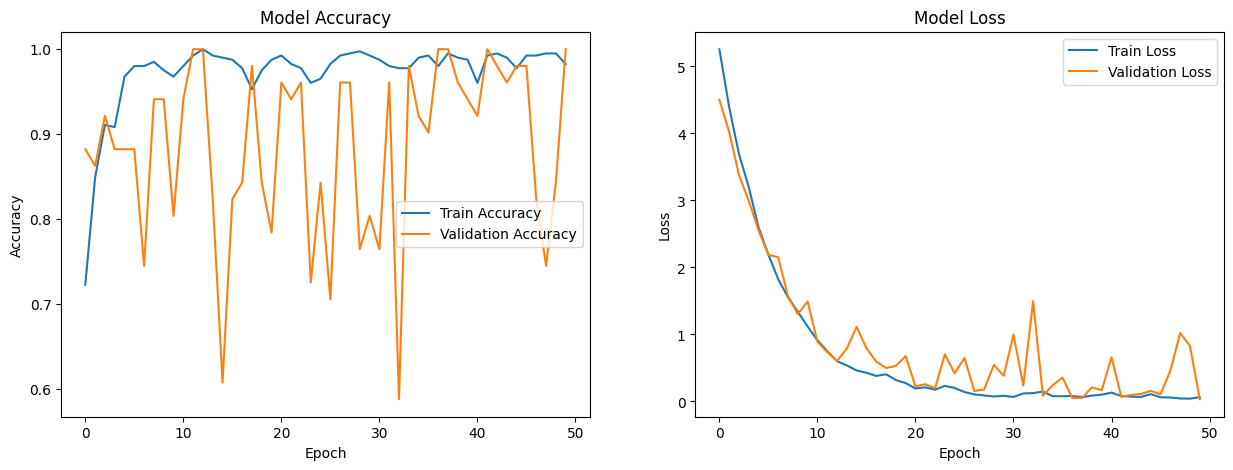

In [10]:
def plot_training_history(history):
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))

    # Plot accuracy
    axs[0].plot(history.history['accuracy'], label='Train Accuracy')
    axs[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
    axs[0].set_title('Model Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Accuracy')
    axs[0].legend()

    # Plot loss
    axs[1].plot(history.history['loss'], label='Train Loss')
    axs[1].plot(history.history['val_loss'], label='Validation Loss')
    axs[1].set_title('Model Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Loss')
    axs[1].legend()

    plt.show()

plot_training_history(history)

In [ ]:
if not os.path.exists('models'):
    os.makedirs('models')
model.save('models/brain_tumor_detection_model.h5')